In [144]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [145]:
!pip install torch_geometric
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.nn import functional as F
from sklearn.metrics import classification_report
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx



In [146]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/EEG.machinelearing_data_BRMH.csv")


print(data.info())
print("\n")
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB
None


   no. sex   age    eeg.date  education     IQ       main.disorder  \
0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   

      specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
0  Alcohol use disorder         35.998557         21.717375  ...   
1  Alcohol use disorder         13.425118         11.002916  ...   
2  Alcohol use disorder         29.941780         27.544684  ...   
3  Alcohol use disorder         21.496226         21.846832  ...   
4  Alcohol use disorder         37.775667  

In [147]:
print(data.describe())


              no.         age   education          IQ  AB.A.delta.a.FP1  \
count  945.000000  945.000000  930.000000  932.000000        945.000000   
mean   473.000000   30.594804   13.438710  101.580472         20.182936   
std    272.942302   11.781592    2.550461   17.022414         11.282022   
min      1.000000   18.000000    0.000000   49.000000          3.272260   
25%    237.000000   21.730000   12.000000   91.000000         12.784872   
50%    473.000000   26.150000   13.000000  102.000000         17.065286   
75%    709.000000   35.450000   16.000000  114.000000         24.492760   
max    945.000000   71.880000   20.000000  145.000000         92.826192   

       AB.A.delta.b.FP2  AB.A.delta.c.F7  AB.A.delta.d.F3  AB.A.delta.e.Fz  \
count        945.000000       945.000000       945.000000       945.000000   
mean          21.177584        17.749553        18.901698        20.447079   
std           12.230662        10.003598         9.079482         9.742912   
min         

In [148]:
missing_values = data.isna().sum()

print("Missing values per column:\n", missing_values[missing_values > 0])

total_missing = data.isna().sum().sum()
print("\nTotal number of missing values in the dataset:", total_missing)


Missing values per column:
 education        15
IQ               13
Unnamed: 122    945
dtype: int64

Total number of missing values in the dataset: 973


In [149]:
duplicates = data.duplicated().sum()
print("Total number of duplicate rows:", duplicates)


Total number of duplicate rows: 0


In [150]:
data = data.drop(columns=['Unnamed: 122'])
data['education'].fillna(data['education'].median(), inplace=True)
data['IQ'].fillna(data['IQ'].median(), inplace=True)


In [151]:
print(data.isna().sum())


no.                      0
sex                      0
age                      0
eeg.date                 0
education                0
                        ..
COH.F.gamma.p.P4.r.O1    0
COH.F.gamma.p.P4.s.O2    0
COH.F.gamma.q.T6.r.O1    0
COH.F.gamma.q.T6.s.O2    0
COH.F.gamma.r.O1.s.O2    0
Length: 1148, dtype: int64


In [152]:
print(data['specific.disorder'].unique())

['Alcohol use disorder' 'Acute stress disorder' 'Depressive disorder'
 'Healthy control' 'Behavioral addiction disorder'
 'Obsessive compulsitve disorder' 'Schizophrenia' 'Panic disorder'
 'Social anxiety disorder' 'Posttraumatic stress disorder'
 'Adjustment disorder' 'Bipolar disorder']


In [153]:
print(data['specific.disorder'].value_counts())

specific.disorder
Depressive disorder               199
Schizophrenia                     117
Healthy control                    95
Alcohol use disorder               93
Behavioral addiction disorder      93
Bipolar disorder                   67
Panic disorder                     59
Posttraumatic stress disorder      52
Social anxiety disorder            48
Obsessive compulsitve disorder     46
Acute stress disorder              38
Adjustment disorder                38
Name: count, dtype: int64


<ipython-input-154-a9d70611bbb8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=data["specific.disorder"], palette='Set2')


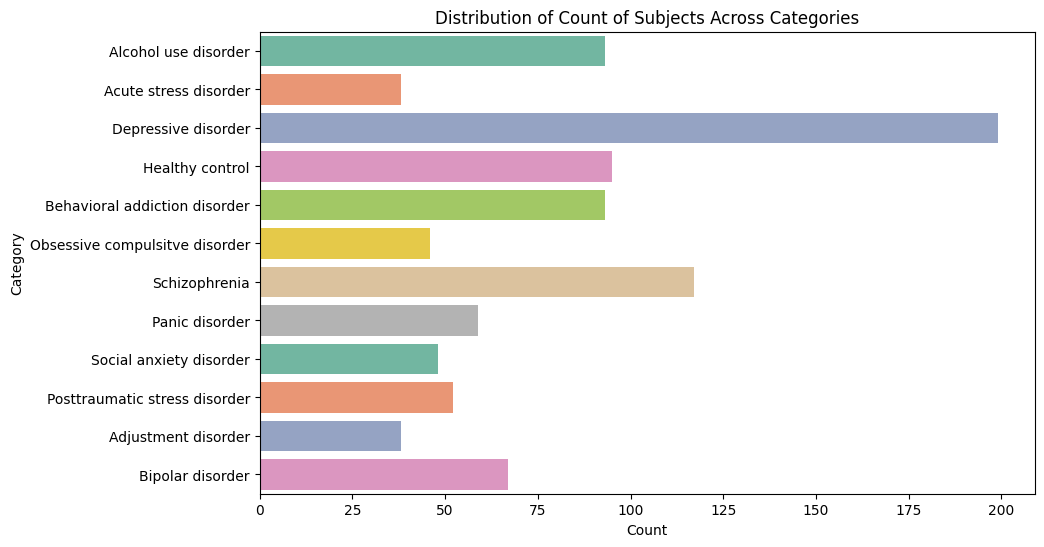

In [154]:

plt.figure(figsize=(10, 6))
sns.countplot(y=data["specific.disorder"], palette='Set2')
plt.title('Distribution of Count of Subjects Across Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


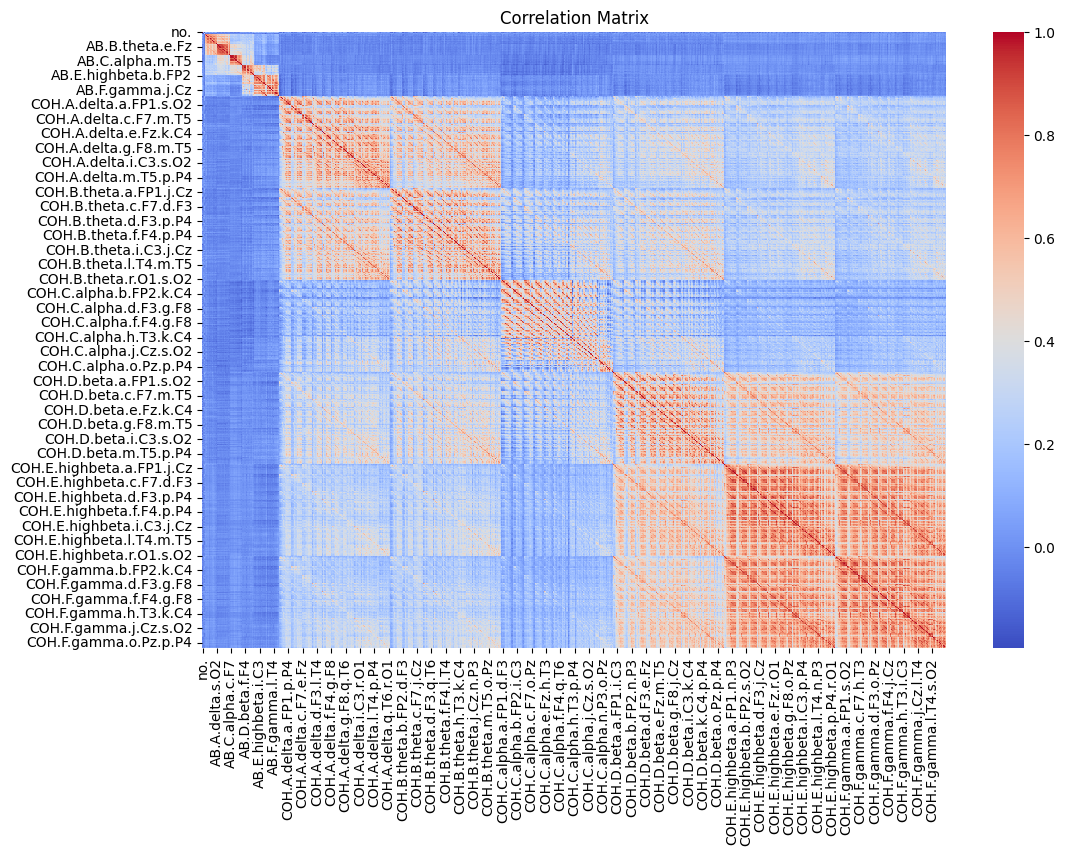

In [155]:
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [156]:
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
print(f"Before dropping co-related columns, dataset size is: {len(data.columns)}")
data = data.drop(columns=to_drop)
print(f"Dropped columns: {to_drop}")
print(f"Size of total Dropped columns: {len(to_drop)}")
print(f"After dropping co-related columns, dataset size is: {len(data.columns)}")


Before dropping co-related columns, dataset size is: 1148
Dropped columns: ['AB.A.delta.f.F4', 'AB.B.theta.b.FP2', 'AB.B.theta.c.F7', 'AB.B.theta.d.F3', 'AB.B.theta.e.Fz', 'AB.B.theta.f.F4', 'AB.B.theta.g.F8', 'AB.B.theta.h.T3', 'AB.B.theta.i.C3', 'AB.B.theta.j.Cz', 'AB.B.theta.k.C4', 'AB.B.theta.l.T4', 'AB.B.theta.n.P3', 'AB.B.theta.o.Pz', 'AB.B.theta.p.P4', 'AB.B.theta.q.T6', 'AB.C.alpha.b.FP2', 'AB.C.alpha.c.F7', 'AB.C.alpha.d.F3', 'AB.C.alpha.e.Fz', 'AB.C.alpha.f.F4', 'AB.C.alpha.g.F8', 'AB.C.alpha.h.T3', 'AB.C.alpha.i.C3', 'AB.C.alpha.j.Cz', 'AB.C.alpha.k.C4', 'AB.C.alpha.l.T4', 'AB.C.alpha.o.Pz', 'AB.C.alpha.p.P4', 'AB.C.alpha.s.O2', 'AB.D.beta.b.FP2', 'AB.D.beta.c.F7', 'AB.D.beta.d.F3', 'AB.D.beta.e.Fz', 'AB.D.beta.f.F4', 'AB.D.beta.g.F8', 'AB.D.beta.i.C3', 'AB.D.beta.k.C4', 'AB.D.beta.o.Pz', 'AB.D.beta.p.P4', 'AB.E.highbeta.b.FP2', 'AB.E.highbeta.e.Fz', 'AB.E.highbeta.f.F4', 'AB.E.highbeta.i.C3', 'AB.E.highbeta.k.C4', 'AB.E.highbeta.o.Pz', 'AB.E.highbeta.p.P4', 'AB.F.gamma.b.FP

In [157]:

irrelevant_columns = ['eeg.date', 'education','IQ']
data = data.drop(columns=irrelevant_columns, errors='ignore')
data.columns

Index(['no.', 'sex', 'age', 'main.disorder', 'specific.disorder',
       'AB.A.delta.a.FP1', 'AB.A.delta.b.FP2', 'AB.A.delta.c.F7',
       'AB.A.delta.d.F3', 'AB.A.delta.e.Fz',
       ...
       'COH.E.highbeta.n.P3.o.Pz', 'COH.E.highbeta.n.P3.p.P4',
       'COH.E.highbeta.n.P3.r.O1', 'COH.E.highbeta.o.Pz.p.P4',
       'COH.E.highbeta.o.Pz.r.O1', 'COH.E.highbeta.o.Pz.s.O2',
       'COH.E.highbeta.p.P4.q.T6', 'COH.E.highbeta.p.P4.s.O2',
       'COH.E.highbeta.q.T6.s.O2', 'COH.E.highbeta.r.O1.s.O2'],
      dtype='object', length=534)

In [158]:
Nodes = [col for col in data.columns if 'AB' in col]
Edges = [col for col in data.columns if 'COH' in col]

print("Nodes Columns:", Nodes)
print("Coherence Columns:", Edges)

Nodes Columns: ['AB.A.delta.a.FP1', 'AB.A.delta.b.FP2', 'AB.A.delta.c.F7', 'AB.A.delta.d.F3', 'AB.A.delta.e.Fz', 'AB.A.delta.g.F8', 'AB.A.delta.h.T3', 'AB.A.delta.i.C3', 'AB.A.delta.j.Cz', 'AB.A.delta.k.C4', 'AB.A.delta.l.T4', 'AB.A.delta.m.T5', 'AB.A.delta.n.P3', 'AB.A.delta.o.Pz', 'AB.A.delta.p.P4', 'AB.A.delta.q.T6', 'AB.A.delta.r.O1', 'AB.A.delta.s.O2', 'AB.B.theta.a.FP1', 'AB.B.theta.m.T5', 'AB.B.theta.r.O1', 'AB.B.theta.s.O2', 'AB.C.alpha.a.FP1', 'AB.C.alpha.m.T5', 'AB.C.alpha.n.P3', 'AB.C.alpha.q.T6', 'AB.C.alpha.r.O1', 'AB.D.beta.a.FP1', 'AB.D.beta.h.T3', 'AB.D.beta.j.Cz', 'AB.D.beta.l.T4', 'AB.D.beta.m.T5', 'AB.D.beta.n.P3', 'AB.D.beta.q.T6', 'AB.D.beta.r.O1', 'AB.D.beta.s.O2', 'AB.E.highbeta.a.FP1', 'AB.E.highbeta.c.F7', 'AB.E.highbeta.d.F3', 'AB.E.highbeta.g.F8', 'AB.E.highbeta.h.T3', 'AB.E.highbeta.j.Cz', 'AB.E.highbeta.l.T4', 'AB.E.highbeta.m.T5', 'AB.E.highbeta.n.P3', 'AB.E.highbeta.q.T6', 'AB.E.highbeta.r.O1', 'AB.E.highbeta.s.O2', 'AB.F.gamma.a.FP1', 'AB.F.gamma.c.F7', 

In [159]:
coherence_matrix = data[Edges].values
print("Edge shape:",coherence_matrix.shape)


Edge shape: (945, 474)


In [160]:
X = data[Nodes].values
print("Node Features Shape:", X.shape)


Node Features Shape: (945, 55)


In [161]:
label_encoder = LabelEncoder()
data['specific.disorder'] = label_encoder.fit_transform(data['specific.disorder'])
Y = data['specific.disorder'].values
print("Target Shape:", Y.shape)

Target Shape: (945,)


In [162]:
num_nodes = X.shape[1]
print(num_nodes)
edge_index = []

for i in range(num_nodes):
    for j in range(num_nodes):
        edge_index.append([i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).T

edge_attr = torch.tensor(coherence_matrix.flatten(), dtype=torch.float)
print(f'length of the edge_index: {len(edge_index)}')
print(f'length of the edge_attr: {len(edge_attr)}')

55
length of the edge_index: 2
length of the edge_attr: 447930


In [163]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
x = torch.tensor(X_scaled, dtype=torch.float)


y = torch.tensor(Y, dtype=torch.long)

graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


In [164]:
# Print graph information
print("Graph Information:")
print(f"Number of Nodes: {graph_data.num_nodes}")
print(f"Number of Edges: {graph_data.num_edges}")
print(f"Node Features Shape: {graph_data.x.shape}")
print(f"Edge Index Shape: {graph_data.edge_index.shape}")
print(f"Edge Attributes Shape: {graph_data.edge_attr.shape if graph_data.edge_attr is not None else 'None'}")
print(f"Labels Shape: {graph_data.y.shape}")


Graph Information:
Number of Nodes: 945
Number of Edges: 3025
Node Features Shape: torch.Size([945, 55])
Edge Index Shape: torch.Size([2, 3025])
Edge Attributes Shape: torch.Size([447930])
Labels Shape: torch.Size([945])


In [180]:
# Simplified GCN with 2 convolutional layers
# class GCN(torch.nn.Module):
#     def __init__(self):
#         super(GCN, self).__init__()
#         self.conv1 = GCNConv(x.shape[1], 64)
#         self.conv2 = GCNConv(64,12)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         return F.log_softmax(x, dim=1)


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(x.shape[1], 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 12)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)



In [182]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out, graph_data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

size=len(graph_data.y)
def evaluate():
    model.eval()
    _, pred = model(graph_data).max(dim=1)
    correct = int(pred.eq(graph_data.y).sum().item())
    accuracy = correct / size
    return accuracy


In [183]:
def classification_report_fn():
    model.eval()
    _, pred = model(graph_data).max(dim=1)
    report = classification_report(graph_data.y.cpu().numpy(), pred.cpu().numpy(), target_names=label_encoder.classes_)
    print(report)
# Training loop
for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        acc = evaluate()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')

classification_report_fn()


Epoch 10, Loss: 2.0112, Accuracy: 0.3460
Epoch 20, Loss: 1.5630, Accuracy: 0.4878
Epoch 30, Loss: 1.1438, Accuracy: 0.6360
Epoch 40, Loss: 0.8132, Accuracy: 0.7556
Epoch 50, Loss: 0.5809, Accuracy: 0.8413
Epoch 60, Loss: 0.4026, Accuracy: 0.8995
Epoch 70, Loss: 0.2950, Accuracy: 0.9259
Epoch 80, Loss: 0.2128, Accuracy: 0.9492
Epoch 90, Loss: 0.1603, Accuracy: 0.9534
Epoch 100, Loss: 0.1254, Accuracy: 0.9630
Epoch 110, Loss: 0.0998, Accuracy: 0.9683
Epoch 120, Loss: 0.0836, Accuracy: 0.9735
Epoch 130, Loss: 0.0731, Accuracy: 0.9661
Epoch 140, Loss: 0.0662, Accuracy: 0.9661
Epoch 150, Loss: 0.0601, Accuracy: 0.9735
Epoch 160, Loss: 0.0567, Accuracy: 0.9735
Epoch 170, Loss: 0.0540, Accuracy: 0.9735
Epoch 180, Loss: 0.0520, Accuracy: 0.9735
Epoch 190, Loss: 0.0506, Accuracy: 0.9735
Epoch 200, Loss: 0.0498, Accuracy: 0.9661
                                precision    recall  f1-score   support

         Acute stress disorder       0.55      1.00      0.71        38
           Adjustment di

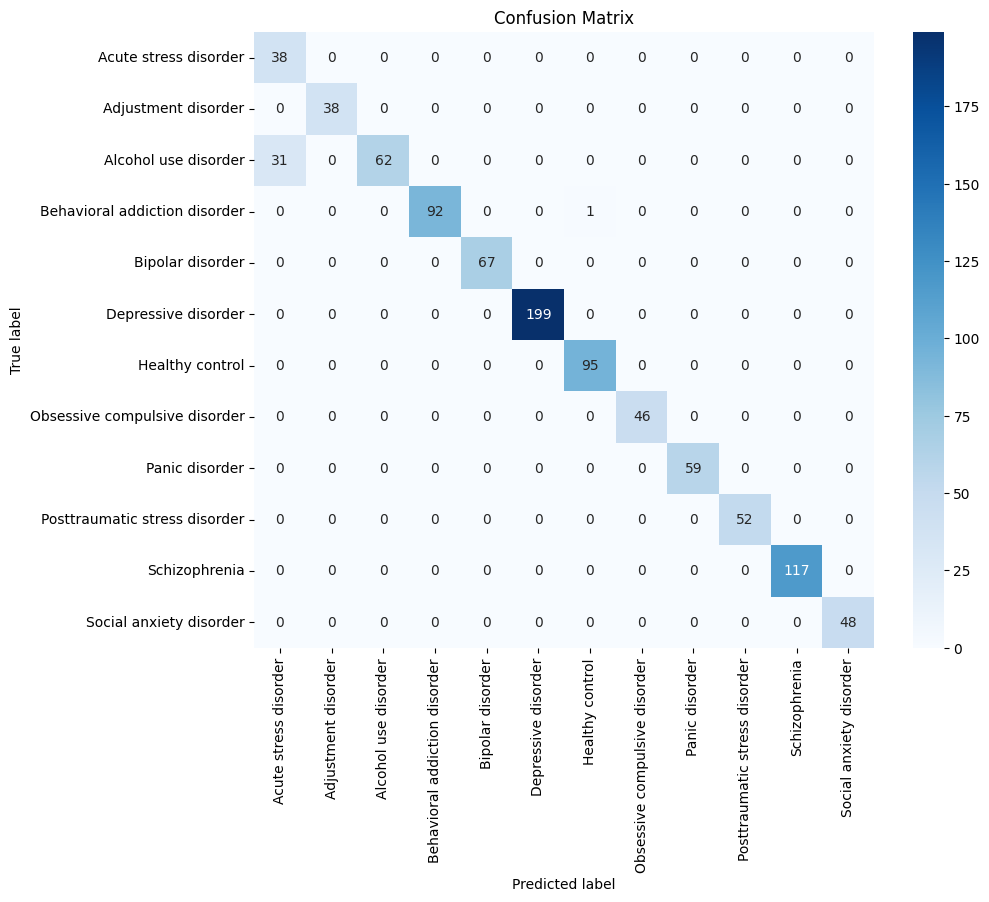

                               precision    recall  f1-score   support

        Acute stress disorder       0.55      1.00      0.71        38
          Adjustment disorder       1.00      1.00      1.00        38
         Alcohol use disorder       1.00      0.67      0.80        93
Behavioral addiction disorder       1.00      0.99      0.99        93
             Bipolar disorder       1.00      1.00      1.00        67
          Depressive disorder       1.00      1.00      1.00       199
              Healthy control       0.99      1.00      0.99        95
Obsessive compulsive disorder       1.00      1.00      1.00        46
               Panic disorder       1.00      1.00      1.00        59
Posttraumatic stress disorder       1.00      1.00      1.00        52
                Schizophrenia       1.00      1.00      1.00       117
      Social anxiety disorder       1.00      1.00      1.00        48

                     accuracy                           0.97       945
    

In [184]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming y_true are the true labels and y_pred are the predicted labels
model.eval()
_, y_pred = model(graph_data).max(dim=1)

# Set your true labels
y_true = graph_data.y.cpu().numpy()  # Use the labels from the graph data

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred.cpu().numpy(), class_names)

# Print classification report
print(classification_report(y_true, y_pred.cpu().numpy(), target_names=class_names))



In [175]:
# @title Checking
def predict_disorder(psd_values, coherence_matrix):
    model.eval()

    # Standardize the input PSD values using the same scaler (if you used one during training)
    scaler = StandardScaler()
    psd_values_scaled = scaler.fit_transform(psd_values)

    # Check if the input features match the model's input features (e.g., 55 features)
    expected_feature_size = 55  # Change this to match the model's expected input size
    if psd_values_scaled.shape[1] != expected_feature_size:
        # Option 1: Reshape by padding with zeros
        if psd_values_scaled.shape[1] < expected_feature_size:
            # Pad with zeros if input has fewer features than expected
            psd_values_scaled = np.pad(psd_values_scaled,
                                       ((0, 0), (0, expected_feature_size - psd_values_scaled.shape[1])),
                                       mode='constant')
        else:
            # Option 2: Truncate features if input has more than expected
            psd_values_scaled = psd_values_scaled[:, :expected_feature_size]

    # Convert to tensor
    x = torch.tensor(psd_values_scaled, dtype=torch.float)

    # Create a fully connected graph with edge_index
    num_nodes = psd_values.shape[0]  # e.g., 19 nodes for 19 electrodes
    edge_index = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            edge_index.append([i, j])

    edge_index = torch.tensor(edge_index, dtype=torch.long).T

    # Coherence matrix is flattened to create edge attributes
    edge_attr = torch.tensor(coherence_matrix.flatten(), dtype=torch.float)

    # Create the graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # Use the trained model to make predictions
    with torch.no_grad():
        output = model(graph_data)
        _, predicted_class_per_node = torch.max(output, dim=1)

    # Aggregate predictions from all nodes (e.g., majority vote)
    predicted_class = torch.mode(predicted_class_per_node).values.item()

    # Assuming you have a list of class names corresponding to the disorders
    class_names = ['Acute stress disorder', 'Adjustment disorder', 'Alcohol use disorder',
                   'Behavioral addiction disorder', 'Bipolar disorder', 'Depressive disorder',
                   'Healthy control', 'Obsessive compulsive disorder', 'Panic disorder',
                   'Posttraumatic stress disorder', 'Schizophrenia', 'Social anxiety disorder']

    # Return the predicted disorder
    return class_names[predicted_class]

# Example usage of the function
psd_input = np.random.rand(19, 10)  # Replace with actual PSD values (19 nodes, 10 features per node)
coherence_input = np.random.rand(19, 19)  # Replace with actual coherence matrix (19x19)

predicted_disorder = predict_disorder(psd_input, coherence_input)
print(f"The predicted disorder is: {predicted_disorder}")


The predicted disorder is: Acute stress disorder
